<a href="https://colab.research.google.com/github/rosshalpin/clip-guided-scene-arrangement/blob/main/Simplistic_Agent_One_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-3fb11da8-10c1-60ce-afc4-dfbc40b5944e)


In [1]:
try:
  import clip
  from plot_image_grid import image_grid
  import ray
except ModuleNotFoundError:
  !pip install gym==0.21.0
  !pip install git+https://github.com/openai/CLIP.git
  !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
  # !pip install ray
  !pip install https://s3-us-west-2.amazonaws.com/ray-wheels/latest/ray-3.0.0.dev0-cp37-cp37m-manylinux2014_x86_64.whl
  !pip install lz4
  import clip
  from plot_image_grid import image_grid
  import ray

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'

!ln -s /content/drive/My\ Drive/Colab\ Notebooks/ $nb_path

sys.path.insert(0,nb_path)

!ln -s /content/gdrive/My\ Drive/ /mydrive


if not nb_path in os.environ['PYTHONPATH']:
  os.environ['PYTHONPATH'] += ':'+ nb_path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ln: failed to create symbolic link '/content/notebooks/Colab Notebooks': File exists
ln: failed to create symbolic link '/mydrive': File exists


In [3]:
import os
import torch
import matplotlib.pyplot as plt
from torch import cuda
import pytorch3d
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.ops import sample_points_from_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, join_meshes_as_batch, join_meshes_as_scene, Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights,
    AmbientLights,
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [5]:
# Set paths
DATA_DIR = '/content/drive/My Drive/DissertationProject_v0.0/data'

In [6]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")


In [7]:
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [8]:
from pytorch3d.renderer import (
  HardPhongShader
)

class SceneObject():
    def __init__(self, mesh, scale=1):
      new_mesh = mesh.clone().scale_verts(scale)
      self._mesh = new_mesh
      self._scale = scale
      self._position = self._mesh_position()

    @property
    def mesh(self):
      return self._mesh

    @property
    def position(self):
      return self._position

    @position.setter
    def position(self, value):
      offset = [round(a-b,3) for a, b in zip(value, self._position)]
      self._set_position_helper(offset)

    def _mesh_position(self):
      return [round(float(((c.cpu()[0]+c.cpu()[1])/2)), 3) for c in self._mesh.get_bounding_boxes()[0]]

    def _set_position_helper(self, value):
      offset = self._mesh.verts_padded().new_tensor(value).expand(self._mesh.verts_packed().shape)
      self._mesh = self._mesh.offset_verts(offset)
      self._position = self._mesh_position()

    def translate(self, value):
      self._set_position_helper(value)


class Scene():
  def __init__(self, mesh: list):
    self._mesh = mesh
    self.CAMERA_DIST = 2.
    self.AZIM = 0
    self.ELEV = 50
    self._scene = join_meshes_as_scene(mesh)

  @property
  def scene(self):
    return self._scene

  @scene.setter
  def scene(self, value):
    self._scene = join_meshes_as_scene(value)

  @property
  def _lights(self):
    return PointLights(device=device, location=[[1.0, 0.5, 1.0]])

  @property
  def _cameras(self):
    R, T = look_at_view_transform(dist=self.CAMERA_DIST, azim=self.AZIM, elev=self.ELEV)
    return FoVPerspectiveCameras(device=device, R=R, T=T)

  @property
  def renderer(self):
    return MeshRenderer(
        rasterizer=MeshRasterizer(
            raster_settings=RasterizationSettings(
              image_size=512, 
              faces_per_pixel=1,
              bin_size=None
            )
        ),
        shader=HardPhongShader(
            device=device
        )
    )
  
  def render(self):
    return self.renderer(self.scene, cameras=self._cameras, lights=self._lights).cpu().numpy()


In [9]:
from copy import deepcopy
def get_scene(objs, obs):
  objs = deepcopy(objs)
  for i, obj in enumerate(objs):
    obj.position = obs[i]
  scene = Scene([a.mesh for a in objs])
  images = scene.render()
  new_imgs = []
  for img_ in images:
    render_img = np.copy(Image.fromarray((img_[..., :3] * 255).astype('uint8')))
    new_imgs.append(render_img)
  return new_imgs, scene.scene[0]

In [212]:
from itertools import product, groupby

DIRECTIONS = list(product(range(-1, 2), repeat=3))
ALL_DIRECTIONS = []
ALL_DIRECTIONS += [[round(a * i,2) for a in b] for b in DIRECTIONS for i in np.linspace(0.1,2,4)]
ALL_DIRECTIONS.sort()
ALL_DIRECTIONS = list(ALL_DIRECTIONS for ALL_DIRECTIONS,_ in groupby(ALL_DIRECTIONS))
np.random.shuffle(ALL_DIRECTIONS)
ACTIONS_MAP = {
  i: ALL_DIRECTIONS[i] for i in range(len(ALL_DIRECTIONS))
}

In [255]:
from gym import Env
from gym.spaces import Box, Discrete, MultiDiscrete
from PIL import Image
import random
import copy
from torch import tensor

class CustomTrain(Env):
  def __init__(self, limit=None):

    fruit_mesh = self.load_mesh(f"{DATA_DIR}/fruit_mesh/pear_export.obj")
    table_mesh = self.load_mesh(f"{DATA_DIR}/table_mesh/GenericClassicTable001.obj")
    fruit_object = SceneObject(fruit_mesh, scale=0.04)
    table_object = SceneObject(table_mesh)
    table_object.position=[0,0,0]
    device = "cuda" if torch.cuda.is_available() else "cpu"
    self.model, self.preprocess = clip.load("ViT-B/32", device=device)
    self.model.cuda().eval()
    self.observation_space = Box(low=0, high=1, shape=(1,))
    self.action_space = Discrete(len(ACTIONS_MAP))#Box(low=-.5, high=.5, shape=(3,))
    self.rounds = 0
    self.limit = limit
    self.reward = -1 
    self.GUIDE_STRING = "Photo of a large green fruit on a table"
    self.objs =  [copy.deepcopy(obj) for obj in [fruit_object, table_object]]
    self.objs[0].position = [0.,0.,0.]
    self.scene = Scene([a.mesh for a in self.objs])
    self.camera = self.scene._cameras
    self.state = self.objs[0].position
    self.highest_sim = -1
    self.image = None
    self.stuck_counter = 0
    self.limit_box = [[-3,0,-3],[3,3,3]]
    self.best_pos = [a.position for a in self.objs]

  def load_mesh(self, input_path) -> Meshes:
    obj_filename = os.path.join(DATA_DIR, input_path)
    return load_objs_as_meshes([obj_filename], device=device)

  def clip_similarity(self, images: list, description: str):
    text_tokens = clip.tokenize([description]).cuda()
    images = map(self.preprocess, images)
    image_input =  torch.tensor(np.stack(images)).cuda()
    with torch.no_grad():
      image_features = self.model.encode_image(image_input).float()
      text_features = self.model.encode_text(text_tokens).float()

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

    return similarity[0]

  def get_pil_image(self, input):
    return Image.fromarray((input * 255).astype('uint8'))

  def get_similarity(self):
    scene = Scene([a.mesh for a in self.objs])
    image = scene.render()
    pil_image = self.get_pil_image(image[0, ..., :3])
    return self.clip_similarity([pil_image], self.GUIDE_STRING)

  def limit_action(self, action, obj):
    translation_result = [a+b for a,b in zip (obj.position, action)]
    for i, val in enumerate(translation_result):
        if val < self.limit_box[0][i]:
            return True
        elif val > self.limit_box[1][i]:
            return True
    return False

  def check_on_camera(self, pos):
    center = tensor(np.reshape(pos, (1,1,3)),dtype=torch.float32, device=device)
    xy = self.camera.transform_points(center)[:, :, :2].cpu().numpy()
    out_of_view = False
    for j in range(1):
      pix_pos = [((i + 1.0) * 256 - 1.0)/2.0 for i in xy[j,0]]
      out_of_view = any(n <= 0 or n >= 256 for n in pix_pos)
      if out_of_view:
        break
    return out_of_view
  
  def step(self, action):
    info = {}
    done = False
    rw = -1
    self.rounds += 1

    action = ACTIONS_MAP[action]

    # action_a = self.limit_action(action[:3], self.objs[0])
    # action_b = self.limit_action(action[3:], self.objs[1])
    # self.objs[1].translate(action_b)

    new_pos = [a+b for a,b in zip (self.objs[0].position, action)]

    out_of_view = self.check_on_camera(new_pos)

    if out_of_view:
      new_pos = self.objs[0].position

    if self.limit_action(action, self.objs[0]):
      new_pos = self.objs[0].position

    self.objs[0].position = new_pos

    # self.objs[0].translate(action)
    # self.objs[0].position = [0.,0.,0.]
    
    obs = np.array(self.get_similarity()).astype(np.float32)

    similarity = obs[0]

    if similarity > self.highest_sim:
      self.highest_sim = similarity
      self.best_pos = [a.position for a in self.objs]
      rw += 1

    if similarity > 0.29:
      rw += 2
      done = True
    elif similarity > 0.28:
      rw += 1
    elif similarity < 0.25:
      rw += -1
      done = True
    # elif similarity < 0.297 and similarity > 0.26:
    #   rw += -1
    




    # if similarity < 0.195:
    #   rw = -2
    #   done = True

    self.reward += rw
    
    if self.limit and self.rounds > self.limit:
      done = True

    return obs, rw, done, info
  
  def reset(self):
    # self.state = np.array([0.,0.,0.])
    self.rounds=0
    self.reward=0
    self.highest_sim=-1
    self.objs[0].position = [0.,0.,0.]
    return np.array([0]).astype(np.float32)

  def render(self, mode):
    pass

In [209]:
env = CustomTrain(limit=50)

In [210]:
env.reset()
done = False
count = 0
while not done:
  count += 1
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  print(obs, reward, done)

[0.22061911] -1 True


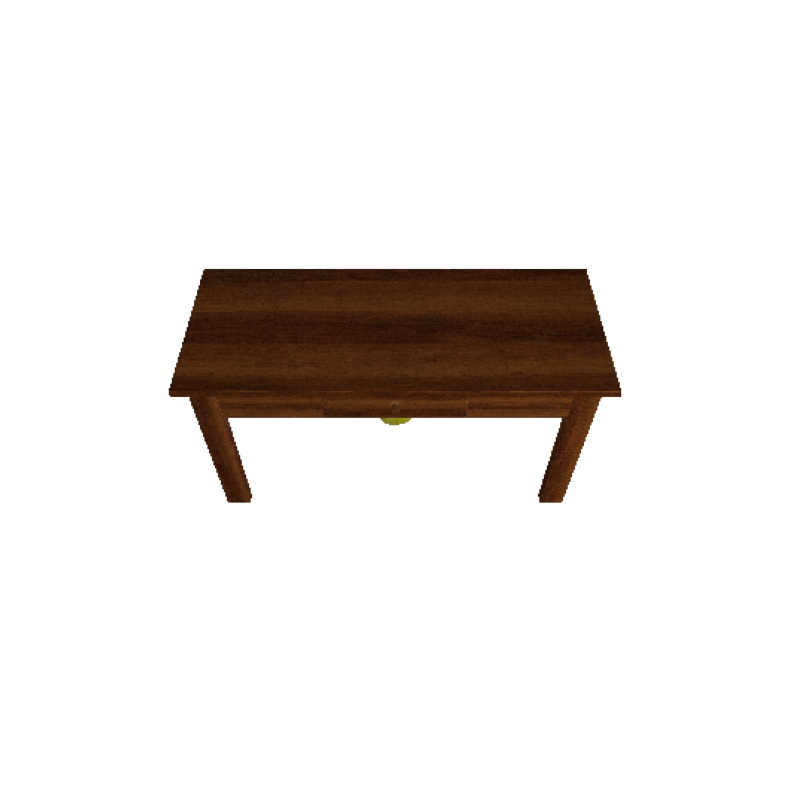

In [211]:
from torch import cuda
images, scene = get_scene(env.objs, env.best_pos)
cuda.empty_cache()
plt.figure(figsize=(7, 7))
plt.imshow(images[0])
plt.grid("off");
plt.axis("off");

In [18]:
plot_batch_individually(scene)

In [14]:
import ray

ray.shutdown()
ray.init(ignore_reinit_error=True)

Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2022-08-27 11:10:08,597	INFO worker.py:1421 -- Started a local Ray instance.


RayContext(dashboard_url='', python_version='3.7.13', ray_version='3.0.0.dev0', ray_commit='bbd13ddc3361bbdd15fa93fe6ef4f30eec68b5c0', address_info={'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-08-27_11-10-06_142356_788/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-08-27_11-10-06_142356_788/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-08-27_11-10-06_142356_788', 'metrics_export_port': 58367, 'gcs_address': '172.28.0.2:64610', 'address': '172.28.0.2:64610', 'dashboard_agent_listen_port': 52365, 'node_id': 'ce543e1a93b9053aaeb2dbc789a80bfaf96d9c5ec28293669f092409'})

In [256]:
from ray.tune.registry import register_env

def env_creator(args):
  return CustomTrain()


register_env("clip_guided", env_creator)

In [16]:
from ray.rllib.algorithms.ppo import PPO

In [ ]:
import ray.rllib.algorithms.ppo as ppo
ppo.DEFAULT_CONFIG.copy()

In [ ]:
# ppo_agent = PPO(
#     env="clip_guided",
#     config={
#       "num_workers": 0,
#       "num_gpus": 1,
#       "horizon": 50,
#       "gamma": 0.90,
#       "lr": 0.002,
#       "framework": "tf2",
#       "eager_tracing": True,
#       "sgd_minibatch_size": 50,
#       "train_batch_size": 5120,
#       "normalize_actions": True,
#     })

# cuda.empty_cache()

In [ ]:
# ppo_agent.train()

In [34]:
# from ray import air, tune
# from ray.tune.schedulers import PopulationBasedTraining

# # Postprocess the perturbed config to ensure it's still valid
# def explore(config):
#     # ensure we collect enough timesteps to do sgd
#     if config["train_batch_size"] < config["sgd_minibatch_size"] * 2:
#         config["train_batch_size"] = config["sgd_minibatch_size"] * 2
#     # ensure we run at least one sgd iter
#     if config["num_sgd_iter"] < 1:
#         config["num_sgd_iter"] = 1
#     return config

# pbt = PopulationBasedTraining(
#     time_attr="time_total_s",
#     perturbation_interval=120,
#     resample_probability=0.25,
#     # Specifies the mutations of these hyperparams
#     hyperparam_mutations={
#         "lr": [1e-3, 5e-4, 1e-4],
#         "num_sgd_iter": lambda: random.randint(2, 10),
#         "sgd_minibatch_size": lambda: random.randint(128, 256),
#         "train_batch_size": lambda: random.randint(500, 2000),
#     },
#     custom_explore_fn=explore,
# )

# tuner = tune.Tuner(
#     "PPO",
#     tune_config=tune.TuneConfig(
#         metric="episode_reward_mean",
#         mode="max",
#         scheduler=pbt,
#         num_samples=1,
#     ),
#     param_space={
#         "env": "clip_guided",
#         "kl_coeff": 1.0,
#         "num_workers": 0,
#         "num_gpus": 1, # number of GPUs to use
#         "model": {"free_log_std": True},
#         # These params are tuned from a fixed starting value.
#         "lr": 1e-4,
#         "horizon": 50,
#         "framework": "tf2",
#         "eager_tracing": True,
#         "eager_max_retraces": None,
#         # These params start off randomly drawn from a set.
#         "num_sgd_iter": tune.choice([2, 10]),
#         "sgd_minibatch_size": tune.choice([128, 256]),
#         "train_batch_size": tune.choice([500, 1000, 2000]),
#     },
# )

In [ ]:
# results = tuner.fit()

In [36]:
# print("best hyperparameters: ", results.get_best_result().config)

best hyperparameters:  {'extra_python_environs_for_driver': {}, 'extra_python_environs_for_worker': {}, 'num_gpus': 1, 'num_cpus_per_worker': 1, 'num_gpus_per_worker': 0, '_fake_gpus': False, 'custom_resources_per_worker': {}, 'placement_strategy': 'PACK', 'eager_tracing': True, 'eager_max_retraces': None, 'tf_session_args': {'intra_op_parallelism_threads': 2, 'inter_op_parallelism_threads': 2, 'gpu_options': {'allow_growth': True}, 'log_device_placement': False, 'device_count': {'CPU': 1}, 'allow_soft_placement': True}, 'local_tf_session_args': {'intra_op_parallelism_threads': 8, 'inter_op_parallelism_threads': 8}, 'env': 'clip_guided', 'env_config': {}, 'observation_space': None, 'action_space': None, 'env_task_fn': None, 'render_env': False, 'clip_rewards': None, 'normalize_actions': True, 'clip_actions': False, 'disable_env_checking': False, 'num_workers': 0, 'num_envs_per_worker': 1, 'sample_collector': <class 'ray.rllib.evaluation.collectors.simple_list_collector.SimpleListCollec

In [280]:
ppo_agent = PPO(env="clip_guided",config={
  'lr':0.002,
  'framework':'tf2',
  'kl_coeff':0.0,
  'sgd_minibatch_size':256,
  'num_sgd_iter': 5,
  'num_workers': 0,
  'horizon': 50,
  'gamma': 0.99,
  'num_gpus': 1, # number of GPUs to use
  'framework': 'tf2',
  'eager_tracing': True,
  'eager_max_retraces': None,
  'train_batch_size': 1024,
  'entropy_coeff': 0.3
})

2022-08-27 16:39:16,393	WARNING ppo.py:359 -- `train_batch_size` (1024) cannot be achieved with your other settings (num_workers=0 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-08-27 16:39:21,848	WARNING util.py:65 -- Install gputil for GPU system monitoring.


In [281]:
N_ITER = 10

for n in range(N_ITER):
  result = ppo_agent.train()
  print(result)

{'custom_metrics': {}, 'episode_media': {}, 'num_recreated_workers': 0, 'info': {'learner': {'default_policy': {'learner_stats': {'cur_kl_coeff': 0.0, 'cur_lr': 0.0020000000949949026, 'total_loss': 3.8215077, 'policy_loss': -0.052384514, 'vf_loss': 5.260295, 'vf_explained_var': 0.124095246, 'kl': 0.0, 'entropy': 4.621341, 'entropy_coeff': 0.30000001192092896}, 'custom_metrics': {}, 'num_agent_steps_trained': 256.0}}, 'num_env_steps_sampled': 1024, 'num_env_steps_trained': 1024, 'num_agent_steps_sampled': 1024, 'num_agent_steps_trained': 1024}, 'sampler_results': {'episode_reward_max': 2.0, 'episode_reward_min': -46.0, 'episode_reward_mean': -2.206549118387909, 'episode_len_mean': 2.486146095717884, 'episode_media': {}, 'episodes_this_iter': 397, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [-1.0, -1.0, -1.0, -1.0, -30.0, -1.0, -1.0, 2.0, -5.0, -1.0, -1.0, -1.0, -3.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0

In [267]:
test_env = CustomTrain(limit=50)

In [275]:
# Test the trained agent
obs = test_env.reset()
done = False
while not done:
  action = ppo_agent.compute_single_action(obs)
  obs, reward, done, info = test_env.step(action)
  print(obs)

[0.2903511]


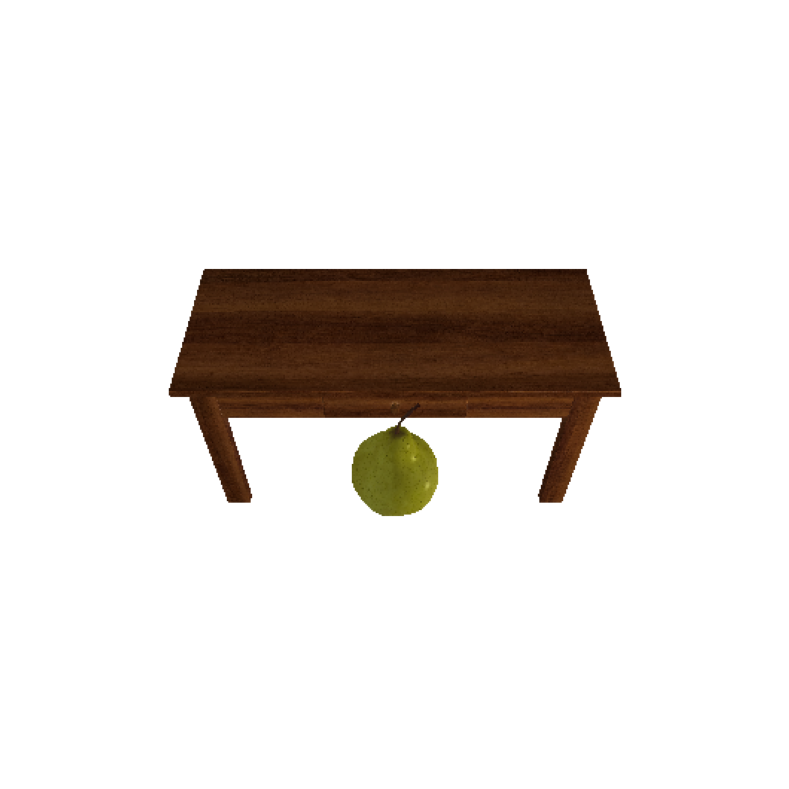

In [276]:
images, scene = get_scene(test_env.objs, test_env.best_pos)
plt.figure(figsize=(7, 7))
plt.imshow(images[0])
plt.grid("off");
plt.axis("off");

In [ ]:
plot_batch_individually(scene)